In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import VotingClassifier

In [16]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.clean_text)

    @staticmethod
    def clean_text(text):
        if pd.isna(text):
            return ''
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
        text = re.sub(r'\d+', ' ', text)      # Remove digits
        text = ' '.join(text.split())        # Normalize whitespace
        return text.strip()

In [17]:
print("Loading data...")
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
combined_df = pd.concat([train_df, test_df], ignore_index=True)

Loading data...


In [18]:
print("Removing rare classes...")
min_instances = 5
category_counts = combined_df['category'].value_counts()
sub_category_counts = combined_df['sub_category'].value_counts()

valid_categories = category_counts[category_counts >= min_instances].index
valid_sub_categories = sub_category_counts[sub_category_counts >= min_instances].index

filtered_df = combined_df[
    (combined_df['category'].isin(valid_categories)) &
    (combined_df['sub_category'].isin(valid_sub_categories))
].copy()

print("Instances removed:", len(combined_df) - len(filtered_df))

Removing rare classes...
Instances removed: 8832


In [19]:
def create_ensemble_pipeline():
    base_classifiers = [
        RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
        GradientBoostingClassifier(n_estimators=50, random_state=42),
        ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    ]

    ensemble_classifier = VotingClassifier(
        estimators=[(f'clf_{i}', clf) for i, clf in enumerate(base_classifiers)],
        voting='hard',
        n_jobs=-1
    )

    pipeline = Pipeline([
        ('cleaner', TextCleaner()),
        ('tfidf', TfidfVectorizer(
            max_features=10000,
            max_df=0.95,
            min_df=2,
            ngram_range=(1, 2),
            stop_words='english'
        )),
        ('clf', MultiOutputClassifier(ensemble_classifier, n_jobs=-1))
    ])

    return pipeline

In [20]:
X = filtered_df['crimeaditionalinfo']
y = filtered_df[['category', 'sub_category']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
print("Training the ensemble model...")
pipeline = create_ensemble_pipeline()
pipeline.fit(X_train, y_train)

Training the ensemble model...


,steps,"[('cleaner', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [22]:
print("Predicting...")
y_pred = pipeline.predict(X_test)

Predicting...


In [23]:
y_pred_category, y_pred_sub_category = y_pred[:, 0], y_pred[:, 1]
y_test_category, y_test_sub_category = y_test['category'], y_test['sub_category']

In [24]:
def calculate_metrics(y_true, y_pred, label):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, average="macro", zero_division=0),
    }

In [25]:
category_metrics = calculate_metrics(y_test_category, y_pred_category, "Category")
sub_category_metrics = calculate_metrics(y_test_sub_category, y_pred_sub_category, "Sub-category")

In [26]:
print("\nCategory Metrics:")
for metric, value in category_metrics.items():
    print(f"{metric}: {value:.4f}")


Category Metrics:
Accuracy: 0.7850
Precision: 0.5282
Recall: 0.2966
F1 Score: 0.3221


In [27]:
print("\nSub-category Metrics:")
for metric, value in sub_category_metrics.items():
    print(f"{metric}: {value:.4f}")


Sub-category Metrics:
Accuracy: 0.5558
Precision: 0.3468
Recall: 0.1916
F1 Score: 0.2106


In [28]:
print("\nCategory Classification Report:")
print(classification_report(y_test_category, y_pred_category, zero_division=0))

print("\nSub-category Classification Report:")
print(classification_report(y_test_sub_category, y_pred_sub_category, zero_division=0))


Category Classification Report:
                                                precision    recall  f1-score   support

                         Any Other Cyber Crime       0.66      0.11      0.18      2893
                          Cryptocurrency Crime       0.85      0.18      0.29       125
                Cyber Attack/ Dependent Crimes       1.00      1.00      1.00       996
                               Cyber Terrorism       0.00      0.00      0.00        41
Hacking  Damage to computercomputer system etc       0.73      0.12      0.21       468
                      Online Cyber Trafficking       0.00      0.00      0.00        58
                        Online Financial Fraud       0.78      0.98      0.87     15216
                      Online Gambling  Betting       0.50      0.01      0.02       120
         Online and Social Media Related Crime       0.76      0.57      0.65      3293
                                    Ransomware       0.00      0.00      0.00         

Plotting confusion matrices...


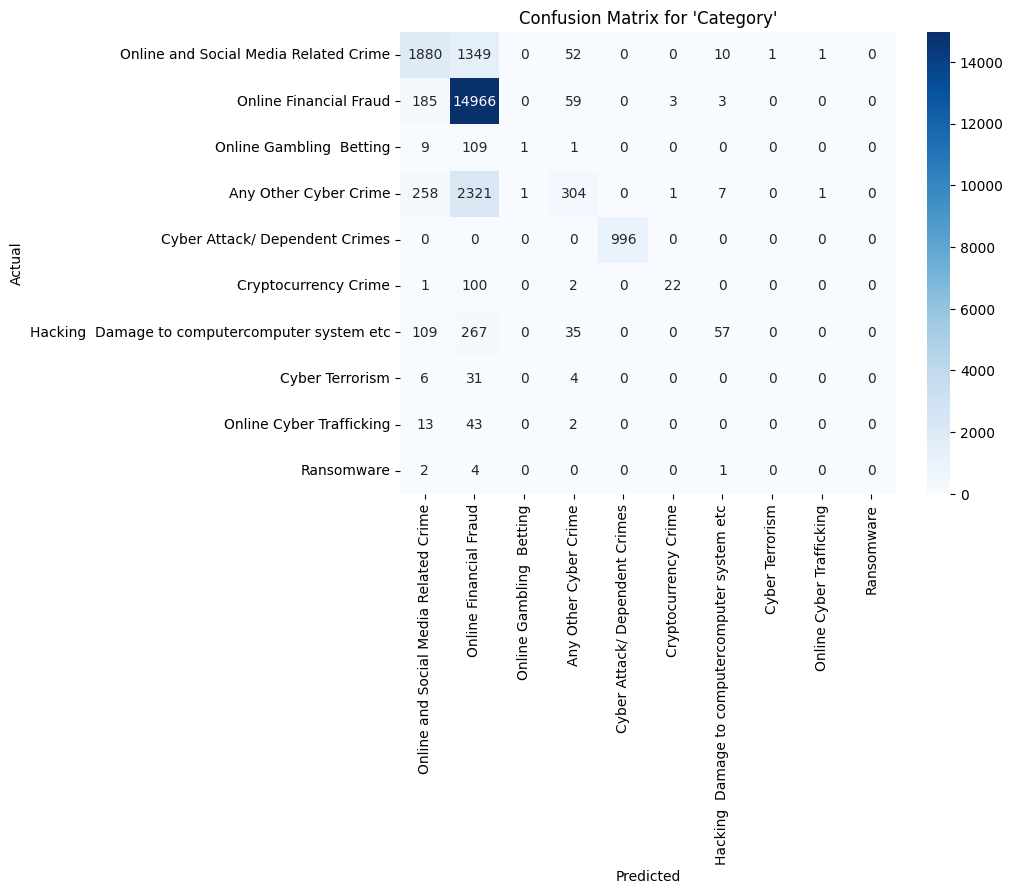

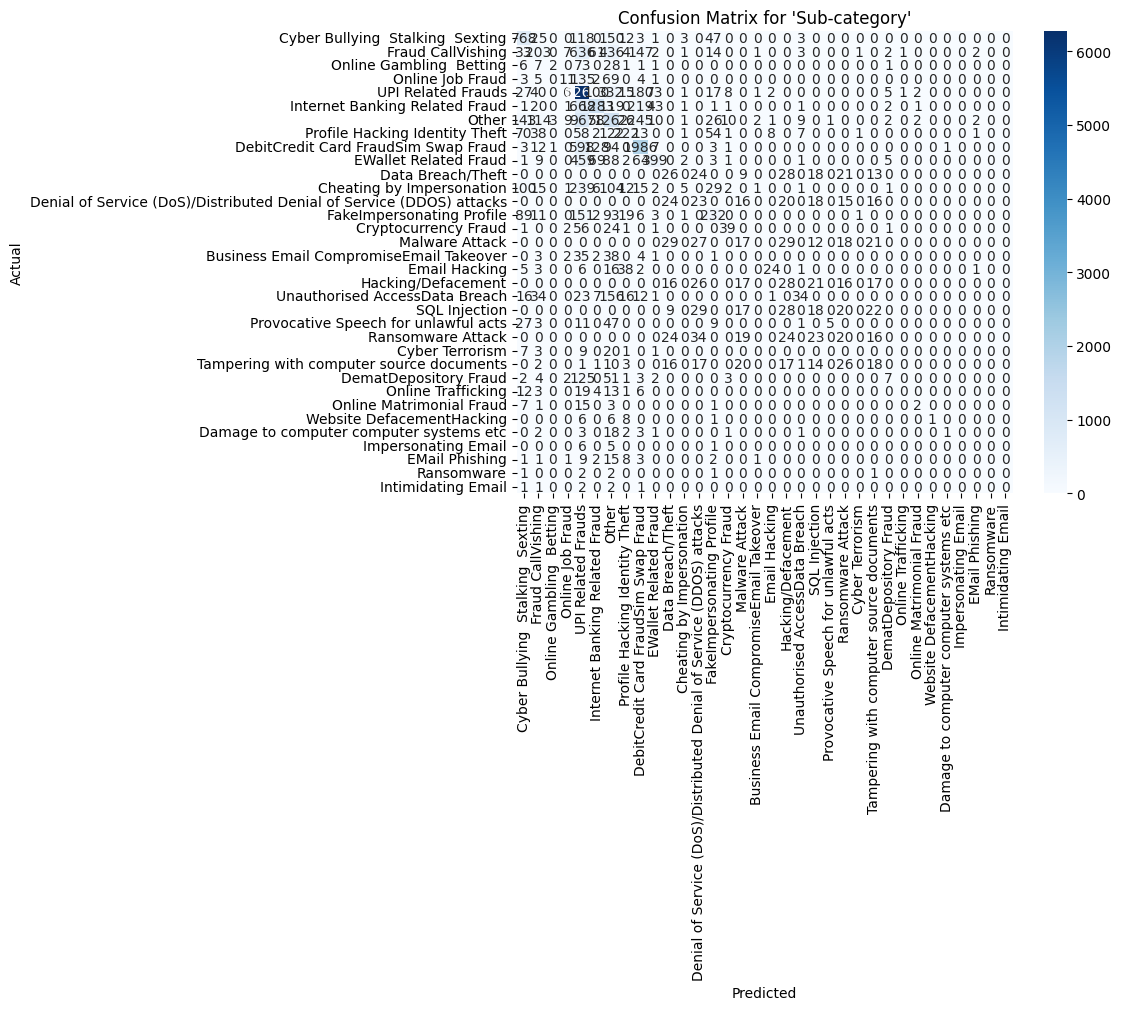

In [29]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

print("Plotting confusion matrices...")
plot_confusion_matrix(y_test_category, y_pred_category, labels=y['category'].unique(), title="Confusion Matrix for 'Category'")
plot_confusion_matrix(y_test_sub_category, y_pred_sub_category, labels=y['sub_category'].unique(), title="Confusion Matrix for 'Sub-category'")

In [30]:
import time
import numpy as np

print("=== PERFORMANCE METRICS ===")

sample_text = X_test.iloc[0:1]
start_time = time.time()
_ = pipeline.predict(sample_text)
latency = (time.time() - start_time) * 1000  # Convert to milliseconds
print(f"Latency: {latency:.2f} ms")

batch_sizes = [1, 10, 100, 1000]
speeds = []

for batch_size in batch_sizes:
    if batch_size <= len(X_test):
        batch = X_test.iloc[:batch_size]
        start_time = time.time()
        _ = pipeline.predict(batch)
        elapsed = time.time() - start_time
        speed = batch_size / elapsed
        speeds.append(speed)
        print(f"Batch size {batch_size}: {speed:.1f} predictions/sec")

print(f"\nScalability Analysis:")
print(f"Max throughput: {max(speeds):.1f} predictions/sec")
print(f"Throughput efficiency: {(max(speeds)/speeds[0]):.1f}x improvement with batching")

=== PERFORMANCE METRICS ===
Latency: 9276.65 ms
Batch size 1: 0.1 predictions/sec
Batch size 10: 1.1 predictions/sec
Batch size 100: 10.1 predictions/sec
Batch size 1000: 163.3 predictions/sec

Scalability Analysis:
Max throughput: 163.3 predictions/sec
Throughput efficiency: 1183.5x improvement with batching
